In [93]:
# 1. 导入库 & 路径
import os
import pandas as pd
import numpy as np
from statsmodels.imputation.mice import MICEData
import matplotlib.pyplot as plt
import seaborn as sns

# 本地数据路径（WSL 下映射的 G: 盘）
DATA_DIR = "/mnt/g/github_env/imba_data"
OUTPUT_DIR = os.path.join(DATA_DIR, "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [94]:
# 2. 加载订单主表
orders = pd.read_csv(f"{DATA_DIR}/orders.csv")
print("orders shape:", orders.shape)
orders.head()

orders shape: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


3. 数据清洗

In [95]:
# 3.1 类型校验 & cast
orders = orders.astype({
    "order_id": int,
    "user_id": int,
    "order_number": int,
    "order_dow": int,
    "order_hour_of_day": int,
    "days_since_prior_order": float  # NA 保留为 NaN
})


In [96]:
# 3.2 Domain Filter
orders = orders[
    orders.eval_set.isin(["prior","train","test"]) &
    orders.order_dow.between(0,6) &
    orders.order_hour_of_day.between(0,23)
]


In [97]:
# 3.3 IQR 异常值剔除 (示例: days_since_prior_order)
q1, q3 = orders["days_since_prior_order"].quantile([0.25,0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
orders = orders[
    orders.days_since_prior_order.between(lower, upper) | orders.days_since_prior_order.isna()
]


In [98]:
# 3.4 关键字段缺失 & 重复行剔除
orders = orders.dropna(subset=["order_id","user_id","days_since_prior_order"], how="all")
orders = orders.drop_duplicates()

print("Cleaned orders shape:", orders.shape)

Cleaned orders shape: (3421083, 7)


以下是包装后成一个小函数，并在每一步后输出

In [99]:
from typing import Tuple, Dict
import pandas as pd

def clean_orders(
    df: pd.DataFrame,
    eval_sets: list = ["prior", "train", "test"],
    iqr_k: float = 1.5
) -> Tuple[pd.DataFrame, Dict]:
    """
    对 orders 表做以下四步清洗，返回 (cleaned_df, stats)：
      1. cast types
      2. domain filter on eval_set, order_dow, order_hour_of_day
      3. IQR 异常值剔除 (days_since_prior_order)
      4. dropna & dedup

    stats 字典包含每一步的 before/after 行数以及 IQR 边界。
    """
    df0 = df.copy()
    stats = {"initial": len(df0)}

    # 1) 类型校验 & cast
    df1 = df0.astype({
        "order_id": int,
        "user_id": int,
        "order_number": int,
        "order_dow": int,
        "order_hour_of_day": int,
        "days_since_prior_order": float
    })
    stats["after_cast"] = len(df1)

    # 2) Domain Filter
    before = len(df1)
    df2 = df1[
        df1.eval_set.isin(eval_sets) &
        df1.order_dow.between(0, 6) &
        df1.order_hour_of_day.between(0, 23)
    ]
    stats["after_domain"] = len(df2)
    stats["removed_domain"] = before - stats["after_domain"]

    # 3) IQR 异常值剔除
    before = len(df2)
    q1, q3 = df2["days_since_prior_order"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - iqr_k * iqr, q3 + iqr_k * iqr
    df3 = df2[
        df2.days_since_prior_order.between(lower, upper) |
        df2.days_since_prior_order.isna()
    ]
    stats["after_iqr"] = len(df3)
    stats["removed_iqr"] = before - stats["after_iqr"]
    stats["iqr_bounds"] = {"q1": q1, "q3": q3, "lower": lower, "upper": upper}

    # 4) 丢弃关键字段缺失 & 重复行
    before = len(df3)
    df4 = df3.dropna(subset=["order_id", "user_id", "days_since_prior_order"], how="all")
    df4 = df4.drop_duplicates().reset_index(drop=True)
    stats["after_dropna_dedup"] = len(df4)
    stats["removed_dropna_dedup"] = before - stats["after_dropna_dedup"]

    return df4, stats


In [100]:
from IPython.display import display

In [101]:
print("▶️ 原始数据:", orders.shape)
display(orders.head(3))

▶️ 原始数据: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [102]:
# 调用清洗函数
cleaned_orders, clean_stats = clean_orders(orders)

In [103]:
# 打印每步统计
import json
print("Cleaning stats:\n", json.dumps(clean_stats, indent=2))

Cleaning stats:
 {
  "initial": 3421083,
  "after_cast": 3421083,
  "after_domain": 3421083,
  "removed_domain": 0,
  "after_iqr": 3421083,
  "removed_iqr": 0,
  "iqr_bounds": {
    "q1": 4.0,
    "q3": 15.0,
    "lower": -12.5,
    "upper": 31.5
  },
  "after_dropna_dedup": 3421083,
  "removed_dropna_dedup": 0
}


In [104]:
# 原始 vs 清洗后行数对比
print(f"原始行数: {clean_stats['initial']} -> 清洗后: {len(cleaned_orders)}")

原始行数: 3421083 -> 清洗后: 3421083


In [105]:
# 清洗后的表结构 & 缺失
cleaned_orders.info()
print("\n缺失值统计:\n", cleaned_orders.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB

缺失值统计:
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


In [106]:
# 3.1 类型转换后：行 × 列
print(f"3.1 类型转换后：({clean_stats['after_cast']}, {len(cleaned_orders.columns)})")
# 列类型
display(cleaned_orders.dtypes)

3.1 类型转换后：(3421083, 7)


order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [107]:
# 3.2 Domain Filter 后
removed = clean_stats['removed_domain']
print(f"3.2 Domain Filter 后：({clean_stats['after_domain']}, {len(cleaned_orders.columns)}) （剔除 {removed} 行）")
# eval_set 分布
display(cleaned_orders['eval_set'].value_counts())
# 周/小时范围
print("order_dow 范围：", cleaned_orders.order_dow.min(), "–", cleaned_orders.order_dow.max())
print("order_hour_of_day 范围：", cleaned_orders.order_hour_of_day.min(), "–", cleaned_orders.order_hour_of_day.max())

3.2 Domain Filter 后：(3421083, 7) （剔除 0 行）


eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64

order_dow 范围： 0 – 6
order_hour_of_day 范围： 0 – 23


In [108]:
# 3.3 IQR 异常值剔除后
removed = clean_stats['removed_iqr']
print(f"3.3 IQR 异常值剔除后：({clean_stats['after_iqr']}, {len(cleaned_orders.columns)}) （剔除 {removed} 行）")
bounds = clean_stats['iqr_bounds']
print(f"days_since_prior_order 分位数：{bounds['q1']}，{bounds['q3']}  IQR：{bounds['q3']-bounds['q1']}")

3.3 IQR 异常值剔除后：(3421083, 7) （剔除 0 行）
days_since_prior_order 分位数：4.0，15.0  IQR：11.0


In [109]:
# 3.4 缺失 & 重复剔除后
removed = clean_stats['removed_dropna_dedup']
print(f"3.4 缺失 & 重复剔除后：({clean_stats['after_dropna_dedup']}, {len(cleaned_orders.columns)}) （剔除 {removed} 行）")
display(cleaned_orders.head(3))

3.4 缺失 & 重复剔除后：(3421083, 7) （剔除 0 行）


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


/mnt/g/github_env/imba_data/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/g/github_env/imba_data/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


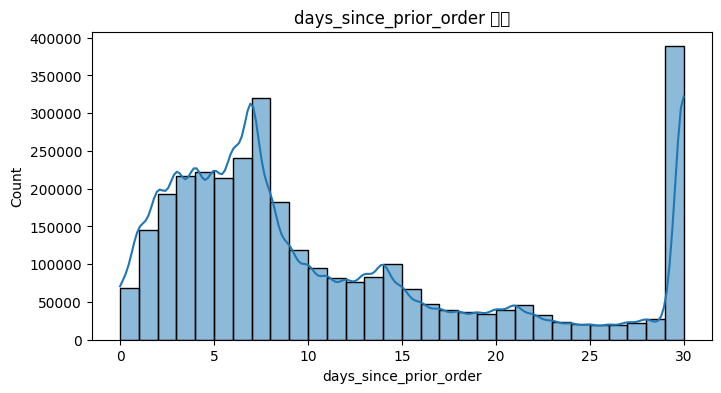

In [110]:
# 关键字段分布
plt.figure(figsize=(8,4))
sns.histplot(cleaned_orders["days_since_prior_order"].dropna(), bins=30, kde=True)
plt.title("days_since_prior_order 分布")
plt.show()

In [111]:
# 周期字段检查
print("order_dow 分布：")
display(cleaned_orders["order_dow"].value_counts().sort_index())
print("\norder_hour_of_day 分布：")
display(cleaned_orders["order_hour_of_day"].value_counts().sort_index())

order_dow 分布：


order_dow
0    600905
1    587478
2    467260
3    436972
4    426339
5    453368
6    448761
Name: count, dtype: int64


order_hour_of_day 分布：


order_hour_of_day
0      22758
1      12398
2       7539
3       5474
4       5527
5       9569
6      30529
7      91868
8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
21     78109
22     61468
23     40043
Name: count, dtype: int64

In [112]:
# 重复行检查
print("重复行数:", cleaned_orders.duplicated().sum())

重复行数: 0


4. 用户级聚合 & 缺失标记

In [113]:
# 按 user 聚合，计算 max_days, days_imp, frequency
user_imp = (
    orders
    .groupby("user_id", as_index=False)
    .agg(
        max_days     = ("days_since_prior_order", lambda s: np.nanmax(s.values)),
        frequency    = ("order_number", "max")
    )
)
# 如果 max_days==30 则我们认为原始数据被截断，将其标记为 NA
user_imp["days_imp"] = user_imp["max_days"].apply(lambda x: np.nan if x==30 else x)
user_imp = user_imp[["user_id","days_imp","frequency"]]
print("After aggregation, missing days_imp:", user_imp["days_imp"].isna().sum())

After aggregation, missing days_imp: 152012


查看 user_imp 结果——包括 shape、前几行、缺失分布和统计摘要：

In [114]:
# 1. 基本信息
print("▶️ user_imp shape:", user_imp.shape)
print("▶️ 缺失 days_imp 数量:", user_imp["days_imp"].isna().sum())
print("▶️ frequency 分布：")
display(user_imp["frequency"].value_counts().sort_index().head(10))


▶️ user_imp shape: (206209, 3)
▶️ 缺失 days_imp 数量: 152012
▶️ frequency 分布：


frequency
4     23986
5     19590
6     16165
7     13850
8     11700
9     10190
10     9032
11     7815
12     6952
13     6236
Name: count, dtype: int64

In [115]:
# 2. 预览前 10 行
print("\n▶️ user_imp head:")
display(user_imp.head(10))



▶️ user_imp head:


,user_id,days_imp,frequency
0,1,NaN,11
1,2,NaN,15
2,3,21.0,13
3,4,NaN,6
4,5,19.0,5
5,6,22.0,4
6,7,NaN,21
7,8,NaN,4
8,9,NaN,4
9,10,NaN,6


In [116]:
# 3. days_imp 值分布（含 NaN）
print("\n▶️ days_imp value counts (包括 NaN):")
display(user_imp["days_imp"].value_counts(dropna=False).sort_index().head(10))



▶️ days_imp value counts (包括 NaN):


days_imp
0.0       6
1.0      27
2.0      44
3.0     108
4.0     228
5.0     402
6.0     536
7.0    1183
8.0    1567
9.0    1367
Name: count, dtype: int64

In [117]:
# 4. days_imp 统计摘要
print("\n▶️ days_imp 描述性统计：")
display(user_imp["days_imp"].describe())



▶️ days_imp 描述性统计：


count    54197.000000
mean        18.821743
std          6.564794
min          0.000000
25%         14.000000
50%         19.000000
75%         24.000000
max         29.000000
Name: days_imp, dtype: float64

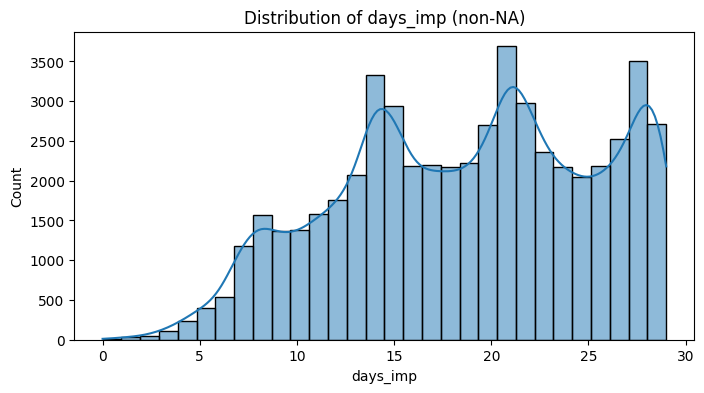

In [118]:
# 5. 可视化——days_imp 分布
plt.figure(figsize=(8,4))
sns.histplot(user_imp["days_imp"].dropna(), bins=30, kde=True)
plt.title("Distribution of days_imp (non-NA)")
plt.xlabel("days_imp")
plt.show()


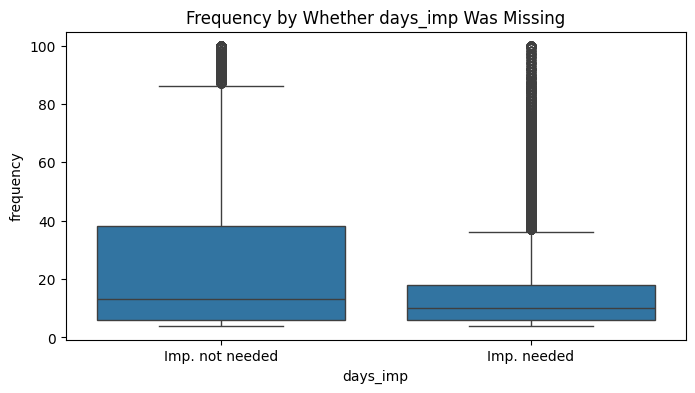

In [119]:
# 6. 可视化——frequency vs. imputed/not
plt.figure(figsize=(8,4))
sns.boxplot(x=user_imp["days_imp"].isna(), y=user_imp["frequency"])
plt.xticks([0,1], ["Imp. not needed","Imp. needed"])
plt.title("Frequency by Whether days_imp Was Missing")
plt.show()


聚合和标记这一步已经跑通，可以得出：
    一共有 206 209 位用户
    有 152 012 位用户因为 max_days==30 被标记为 NaN，需要插补
    剩下 54 197 位用户有可直接观测的 days_imp，分布也如我们预期

5. 多重插补 (MICE)

In [120]:
# 准备数据
mi_df = user_imp[["days_imp","frequency"]].copy()
print("原始缺失数:", mi_df["days_imp"].isna().sum())

# 参数
M, MAX_IT = 7, 10

# 构造 MICEData
mice_data = MICEData(mi_df)

# 执行循环插补
imputed_list = []
for i in range(M):
    mice_data.update_all(n_iter=MAX_IT)   # ⚠️ 这里用 n_iter 而不是 maxiter
    df_imp = mice_data.data.copy()
    df_imp["impute_id"] = i
    imputed_list.append(df_imp)
    print(f"Completed imputation {i+1}/{M}")

# 合并长表
imputed_df = pd.concat(imputed_list, ignore_index=True)
print("合并后形状:", imputed_df.shape)



原始缺失数: 152012
Completed imputation 1/7
Completed imputation 2/7
Completed imputation 3/7
Completed imputation 4/7
Completed imputation 5/7
Completed imputation 6/7
Completed imputation 7/7
合并后形状: (1443463, 3)


请用以下代码 确认你的 statsmodels 版本至少是 0.9.0 或更高；如果低于这个版本，请在你的虚拟环境里运行 pip install --upgrade statsmodels

In [122]:
import statsmodels
print(statsmodels.__version__)

0.14.5


6. 插补后诊断 & 验证

In [123]:
# 计算每份插补的 days_imp 均值与标准差
stats_imp = (
    imputed_df
    .groupby("impute_id")["days_imp"]
    .agg(["mean","std"])
    .reset_index()
)
print("各插补份的统计量：")
display(stats_imp)


各插补份的统计量：


,impute_id,mean,std
0,0,18.991378,6.602576
1,1,18.983720,6.603536
2,2,18.974642,6.611393
3,3,18.961006,6.606639
4,4,18.989593,6.596634
5,5,18.971519,6.599888
6,6,18.976364,6.606314


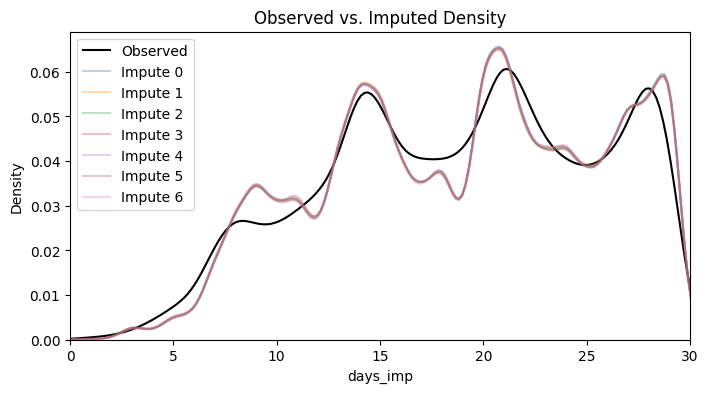

In [124]:
# 插补前后分布对比 - 检查各条插补曲线是否大体跟 Observed 重合，且没有跑偏
plt.figure(figsize=(8,4))

# Observed（原始非 NA）
sns.kdeplot(
    data=user_imp, x="days_imp",
    label="Observed", color="black", fill=False
)
# 每份插补
for i in stats_imp["impute_id"]:
    subset = imputed_df[imputed_df.impute_id == i]
    sns.kdeplot(
        data=subset, x="days_imp",
        label=f"Impute {i}", alpha=0.3, legend=False
    )
plt.title("Observed vs. Imputed Density")
plt.xlim(0, 30)
plt.legend()
plt.show()

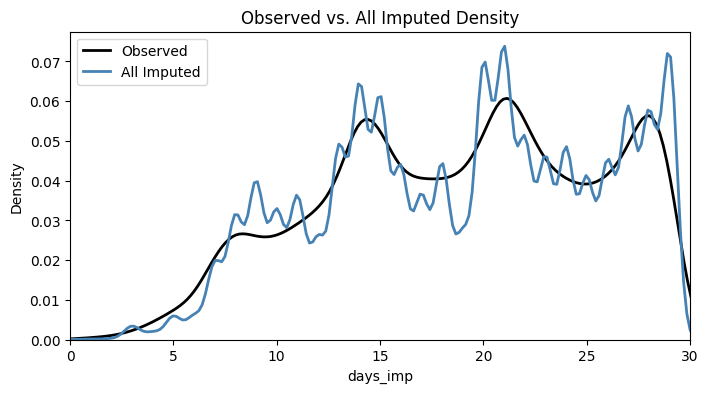

In [125]:
plt.figure(figsize=(8,4))
# 原始（Observed）
sns.kdeplot(
    data=user_imp, x="days_imp",
    label="Observed", color="black", lw=2
)
# 合并后的插补（All Imputed）
sns.kdeplot(
    data=imputed_df, x="days_imp",
    label="All Imputed", color="steelblue", lw=2
)
plt.title("Observed vs. All Imputed Density")
plt.xlim(0, 30)
plt.xlabel("days_imp")
plt.ylabel("Density")
plt.legend()
plt.show()

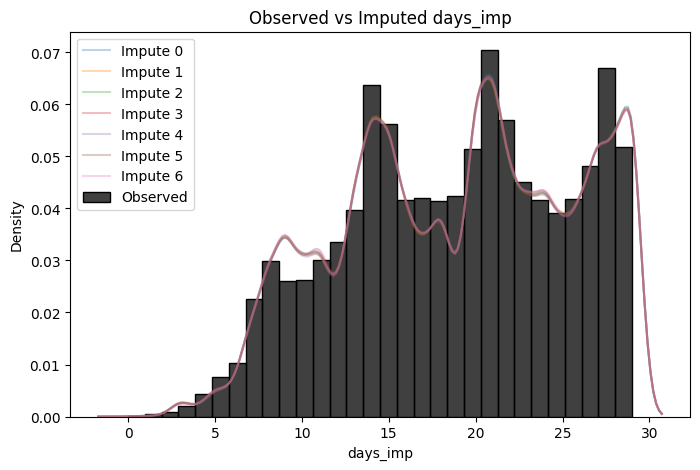

In [126]:
# 6.1 分布对比
plt.figure(figsize=(8,5))
sns.histplot(user_imp["days_imp"].dropna(), color="black", label="Observed", stat="density", bins=30)
for m in range(M):
    sns.kdeplot(imputed_df.loc[imputed_df.impute_id==m,"days_imp"], alpha=0.3, label=f"Impute {m}")
plt.legend()
plt.title("Observed vs Imputed days_imp")
plt.show()

逐迭代记录均值轨迹
在当前的 statsmodels 版本里，MICEData 已不再暴露内部的 data_history 属性，所以直接去读它会报错。为此，要自己“手动”在每次迭代后记录你关心的统计量，来绘制收敛轨迹
下面这种方法不依赖内部的 data_history，而是在每次迭代后手动记录一下总体或缺失值的统计量（如均值、标准差），非常直观


对每一条链都做独立的迭代追踪，然后把它们画在两块面板（mean / sd）里
多链初始化
    每个 chain 都新建一个 MICEData，并且可用 md.set_seed(chain) 保证随机性可控。

单步迭代
    在最外层循环里，每条链跑 MAX_IT 次 update_all(n_iter=1)，每次完都记录 mean 和 std。

数据整形
    把 records 做成一个长格式 DataFrame，再用 melt 同时绘制两个指标（mean、std）。

FacetGrid
    col="metric" 让 mean 和 std 各占一列面板，hue="chain" 让不同链用不同颜色，estimator=None 保证每一条线都被画出来。

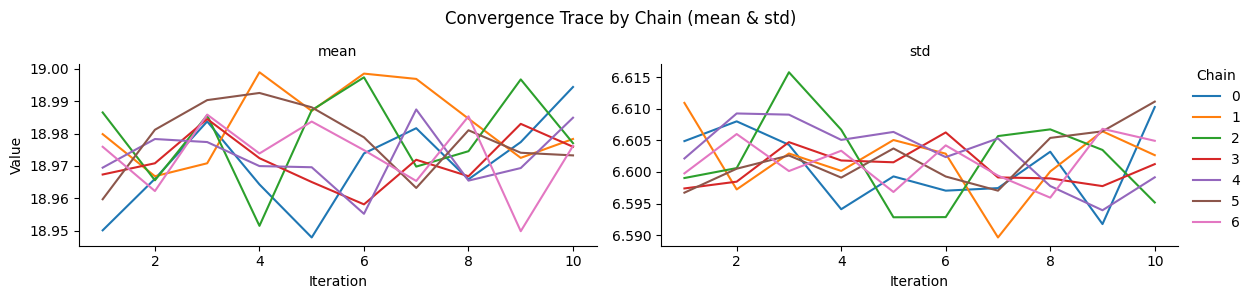

In [130]:
# 1. 参数
M = 7           # 链数（imputations）
MAX_IT = 10     # 每条链的最大迭代次数

# 2. 构造空的记录列表
records = []

# 3. 对每一条链单独初始化并迭代追踪
for chain in range(M):
    # 用全局 seed 区分不同链
    np.random.seed(chain)
    
    # 重置 MICEData
    md = MICEData(user_imp[["days_imp","frequency"]].copy())
    
    # 单步迭代并记录
    for itr in range(1, MAX_IT+1):
        md.update_all(n_iter=1)
        curr = md.data["days_imp"]
        records.append({
            "chain": chain,
            "iter":  itr,
            "mean":  curr.mean(),
            "std":   curr.std()
        })

# 4. 整理成 DataFrame
trace_df = pd.DataFrame(records)

# 5. 把 mean/std 拉成长表，方便 facet 绘图
melted = trace_df.melt(
    id_vars=["chain","iter"],
    value_vars=["mean","std"],
    var_name="metric",
    value_name="value"
)

# 6. 用 Seaborn FacetGrid 分面画出两块：mean & std
g = sns.FacetGrid(
    melted, 
    col="metric", 
    sharey=False,
    height=3, 
    aspect=2
)
g.map_dataframe(
    sns.lineplot,
    x="iter", y="value", 
    hue="chain",
    palette="tab10",
    estimator=None   # 原始线条，不做汇总
)
g.add_legend(title="Chain")
g.set_axis_labels("Iteration","Value")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Convergence Trace by Chain (mean & std)")
plt.show()

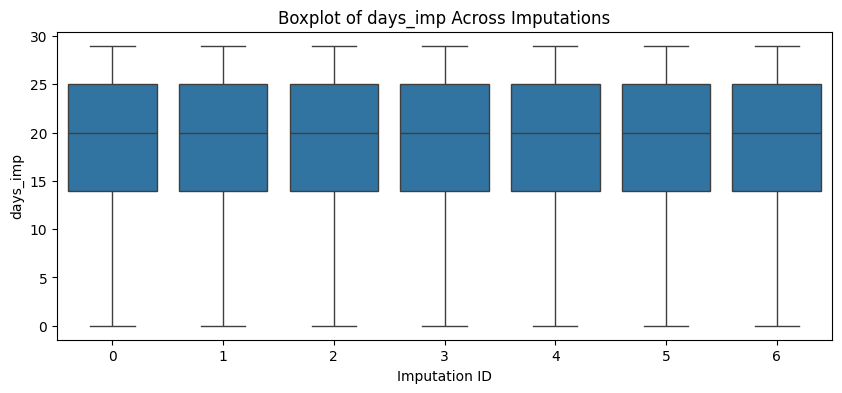

In [131]:
# 箱线图查看各份插补分布 - 看下中位数、上下四分位范围是否几乎重叠
plt.figure(figsize=(10,4))
sns.boxplot(
    data=imputed_df, x="impute_id", y="days_imp"
)
plt.title("Boxplot of days_imp Across Imputations")
plt.xlabel("Imputation ID")
plt.ylabel("days_imp")
plt.show()


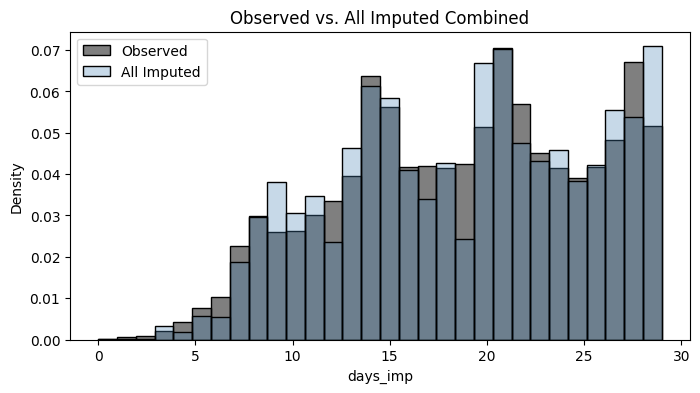

In [132]:
# 最后用叠加直方图（density）再确认一次总体形状是否一致
plt.figure(figsize=(8,4))
# Observed
sns.histplot(
    user_imp["days_imp"].dropna(),
    stat="density", bins=30,
    color="black", alpha=0.5,
    label="Observed"
)
# Imputed 合并
sns.histplot(
    imputed_df["days_imp"],
    stat="density", bins=30,
    color="steelblue", alpha=0.3,
    label="All Imputed"
)
plt.title("Observed vs. All Imputed Combined")
plt.xlabel("days_imp")
plt.ylabel("Density")
plt.legend()
plt.show()